<a href="https://colab.research.google.com/github/NANDAGOPALNG/Food_Vision_101/blob/main/Food_Vision_Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Getting setup

As we've done previously, let's make sure we've got all of the modules we'll need for this section.

We'll import the Python scripts (such as `data_setup.py` and `engine.py`) we created in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/).

To do so, we'll download [`going_modular`](https://github.com/NANDAGOPALNG/pytorch--going_modular/tree/main/going_modular/going_modular) directory from the [`pytorch-deep-learning` repository](https://github.com/NANDAGOPALNG/pytorch--going_modular) (if we don't already have it).

We'll also get the [`torchinfo`](https://github.com/TylerYep/torchinfo) package if it's not available.

`torchinfo` will help later on to give us a visual representation of our model.

And since later on we'll be using `torchvision` v0.13 package (available as of July 2022), we'll make sure we've got the latest versions.

> **Note:** If you're using Google Colab, and you don't have a GPU turned on yet, it's now time to turn one on via `Runtime -> Change runtime type -> Hardware accelerator -> GPU`.

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.8.0+cu126
torchvision version: 0.23.0+cu126


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/NANDAGOPALNG/pytorch--going_modular
    !mv pytorch--going_modular/going_modular .
    !mv pytorch--going_modular/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch--going_modular'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 49 (delta 14), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (49/49), 15.03 MiB | 10.36 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [ ]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## FoodVision Mini model deployment experiment outline

The ideal deployed model FoodVision Mini performs well and fast.

We'd like our model to perform as close to real-time as possible.

Real-time in this case being ~30FPS (frames per second) because that's [about how fast the human eye can see](https://www.healthline.com/health/human-eye-fps) (there is debate on this but let's just use ~30FPS as our benchmark).

And for classifying three different classes (pizza, steak and sushi), we'd like a model that performs at 95%+ accuracy.

goals are:

1. **Performance** - A model that performs at 95%+ accuracy.
2. **Speed** - A model that can classify an image at ~30FPS (0.03 seconds inference time per image, also known as latency).


*FoodVision Mini deployment goals. We'd like a fast predicting well-performing model (because a slow app is boring).*

We'll put an emphasis on speed, meaning, we'd prefer a model performing at 90%+ accuracy at ~30FPS than a model performing 95%+ accuracy at 10FPS.

To try and achieve these results, let's bring in our best performing models from the previous sections:

1. **EffNetB2 feature extractor** (EffNetB2 for short) - originally created in [07. PyTorch Experiment Tracking section 7.5](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#75-create-feature-extractor-models) using [`torchvision.models.efficientnet_b2()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#efficientnet-b2) with adjusted `classifier` layers.
2. **ViT-B/16 feature extractor** (ViT for short) - originally created in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-using-a-pretrained-vit-from-torchvisionmodels-on-the-same-dataset) using [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#vit-b-16) with adjusted `head` layers.
    * **Note** ViT-B/16 stands for "Vision Transformer Base, patch size 16".


## Creating an EffNetB2 feature extractor

We first created an EffNetB2 feature extractor model in [07. PyTorch Experiment Tracking section 7.5](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#75-create-feature-extractor-models).

And by the end of that section we saw it performed very well.

So let's now recreate it here so we can compare its results to a ViT feature extractor trained on the same data.

To do so we can:
1. Setup the pretrained weights as [`weights=torchvision.models.EfficientNet_B2_Weights.DEFAULT`](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.EfficientNet_B2_Weights), where "`DEFAULT`" means "best currently available" (or could use `weights="DEFAULT"`).
2. Get the pretrained model image transforms from the weights with the `transforms()` method (we need these so we can convert our images into the same format as the pretrained EffNetB2 was trained on).
3. Create a pretrained model instance by passing the weights to an instance of [`torchvision.models.efficientnet_b2`](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#efficientnet-b2).
4. Freeze the base layers in the model.
5. Update the classifier head to suit our own data.

In [ ]:
# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use weights="DEFAULT"

# 4. Freeze the base layers in the model (this will freeze all layers to begin with)
for param in effnetb2.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:00<00:00, 99.2MB/s]


In [ ]:
# Check out EffNetB2 classifier head
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [ ]:
# 5. Update the classifier head
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), # keep dropout layer same
    nn.Linear(in_features=1408, # keep in_features same
              out_features=3)) # change out_features to suit our number of classes

In [ ]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

In [ ]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [ ]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output)
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:
# Setup DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [ ]:
import torch
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625


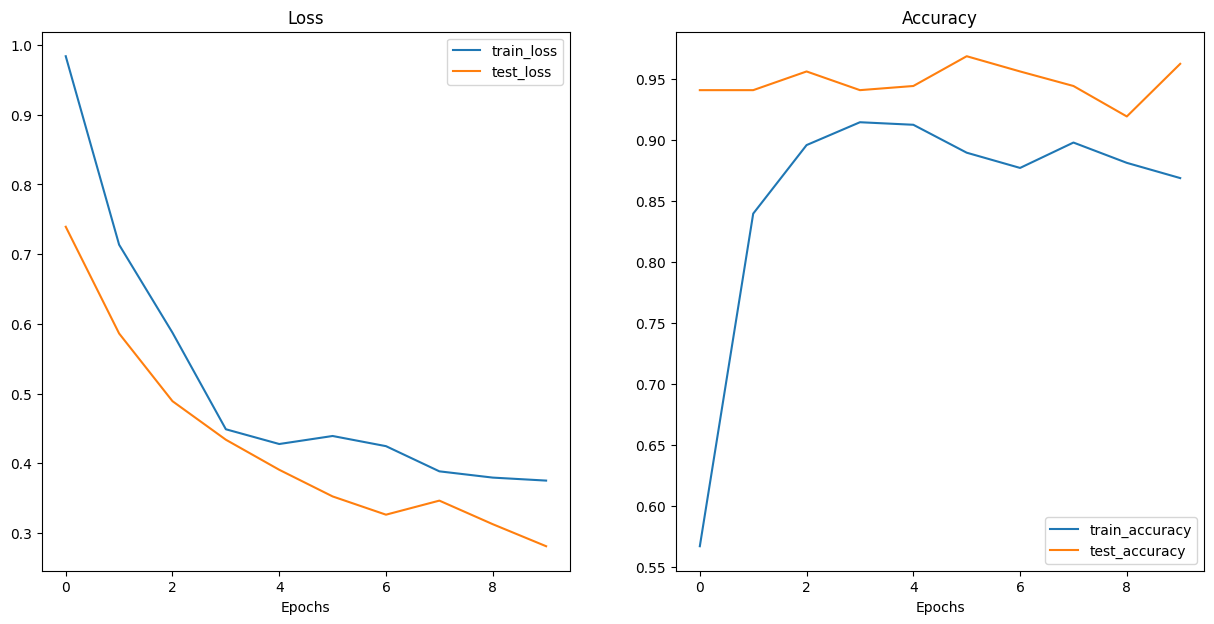

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [ ]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path("models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


In [ ]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [ ]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.28108683228492737,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

## Creating a ViT feature extractor

Time to continue with our FoodVision Mini modelling experiments.

This time we're going to create a ViT feature extractor.

And we'll do it in much the same way as the EffNetB2 feature extractor except this time with [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16) instead of `torchvision.models.efficientnet_b2()`.

We'll start by creating a function called `create_vit_model()` which will be very similar to `create_effnetb2_model()` except of course returning a ViT feature extractor model and transforms rather than EffNetB2.

Another slight difference is that `torchvision.models.vit_b_16()`'s output layer is called `heads` rather than `classifier`.

In [ ]:
# Check out ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model.
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes

    return model, transforms

In [ ]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 183MB/s]


In [ ]:
from torchinfo import summary

# Print ViT feature extractor model summary (uncomment for full output)
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [ ]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


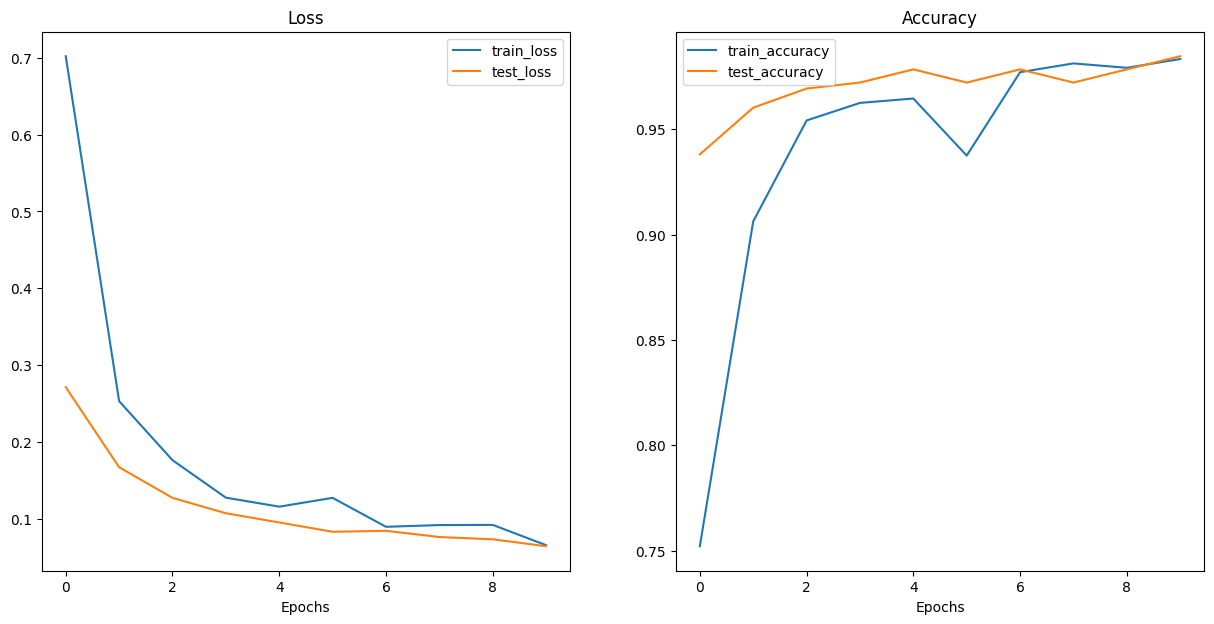

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [ ]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


In [ ]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [ ]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06443452327512204,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

##  Making predictions with our trained models and timing them

We've got a couple of trained models, both performing pretty well.

Now how about we test them out doing what we'd like them to do?

As in, let's see how they go making predictions (performing inference).

We know both of our models are performing at over 95% accuracy on the test dataset, but how fast are they?

Ideally, if we're deploying our FoodVision Mini model to a mobile device so people can take photos of their food and identify it, we'd like the predictions to happen at real-time (~30 frames per second).

That's why our second criteria is: a fast model.

To find out how long each of our models take to performance inference, let's create a function called `pred_and_store()` to iterate over each of the test dataset images one by one and perform a prediction.

We'll time each of the predictions as well as store the results in a common prediction format: a list of dictionaries (where each element in the list is a single prediction and each sinlge prediction is a dictionary).

> **Note:** We time the predictions one by one rather than by batch because when our model is deployed, it will likely only be making a prediction on one image at a time. As in, someone takes a photo and our model predicts on that single image.

Since we'd like to make predictions across all the images in the test set, let's first get a list of all of the test image paths so we can iterate over them.

To do so, we'll use Python's [`pathlib.Path("target_dir").glob("*/*.jpg"))`](https://docs.python.org/3/library/pathlib.html#basic-use) to find all of the filepaths in a target directory with the extension `.jpg` (all of our test images).

In [ ]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/pizza_steak_sushi_20_percent/test


[PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2378406.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/3365273.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/3401466.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1203702.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2743100.jpg')]

###  Creating a function to make predictions across the test dataset

Now we've got a list of our test image paths, let's get to work on our `pred_and_store()` function:

1. Create a function that takes a list of paths, a trained PyTorch model, a series of transforms (to prepare images), a list of target class names and a target device.
2. Create an empty list to store prediction dictionaries (we want the function to return a list of dictionaries, one for each prediction).
3. Loop through the target input paths (steps 4-14 will happen inside the loop).
4. Create an empty dictionary for each iteration in the loop to store prediction values per sample.
5. Get the sample path and ground truth class name (we can do this by inferring the class from the path).
6. Start the prediction timer using Python's [`timeit.default_timer()`](https://docs.python.org/3/library/timeit.html#timeit.default_timer).
7. Open the image using [`PIL.Image.open(path)`](https://pillow.readthedocs.io/en/stable/reference/Image.html#functions).
8. Transform the image so it's capable of being used with the target model as well as add a batch dimension and send the image to the target device.
9. Prepare the model for inference by sending it to the target device and turning on `eval()` mode.
10. Turn on [`torch.inference_mode()`](https://pytorch.org/docs/stable/generated/torch.inference_mode.html) and pass the target transformed image to the model and calculate the prediction probability using `torch.softmax()` and the target label using `torch.argmax()`.
11. Add the prediction probability and prediction class to the prediction dictionary created in step 4. Also make sure the prediction probability is on the CPU so it can be used with non-GPU libraries such as NumPy and pandas for later inspection.
12. End the prediction timer started in step 6 and add the time to the prediction dictionary created in step 4.
13. See if the predicted class matches the ground truth class from step 5 and add the result to the prediction dictionary created in step 4.
14. Append the updated prediction dictionary to the empty list of predictions created in step 2.
15. Return the list of prediction dictionaries.

In [ ]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

    # 2. Create an empty list to store prediction dictionaries
    pred_list = []

    # 3. Loop through target paths
    for path in tqdm(paths):

        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. Start the prediction timer
        start_time = timer()

        # 7. Open image path
        img = Image.open(path)

        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()

        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)

    # 15. Return list of prediction dictionaries
    return pred_list

### Making and timing predictions with EffNetB2

Time to test out our `pred_and_store()` function!

Let's start by using it to make predictions across the test dataset with our EffNetB2 model, paying attention to two details:

1. **Device** - We'll hard code the `device` parameter to use `"cpu"` because when we deploy our model, we won't always have access to a `"cuda"` (GPU) device.
    * Making the predictions on CPU will be a good indicator of speed of inference too because generally predictions on CPU devices are slower than GPU devices.
2. **Transforms** - We'll also be sure to set the `transform` parameter to `effnetb2_transforms` to make sure the images are opened and transformed in the same way our `effnetb2` model has been trained on.

In [ ]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# Inspect the first 2 prediction dictionaries
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2378406.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.51,
  'pred_class': 'sushi',
  'time_for_pred': 0.3727,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/3365273.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9018,
  'pred_class': 'sushi',
  'time_for_pred': 0.1025,
  'correct': True}]

In [ ]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.5100,sushi,0.3727,True
1,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.9018,sushi,0.1025,True
2,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.7560,sushi,0.1007,True
3,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.8756,sushi,0.1137,True
4,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9171,sushi,0.1049,True


In [ ]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

,count
correct,
True,144
False,6


In [ ]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.0974 seconds


In [ ]:
# Add EffNetB2 average prediction time to stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.28108683228492737,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': np.float64(0.0974)}

### Making and timing predictions with ViT

We've made predictions with our EffNetB2 model, now let's do the same for our ViT model.

To do so, we can use the `pred_and_store()` function we created above except this time we'll pass in our `vit` model as well as the `vit_transforms`.

And we'll keep the predictions on the CPU via `device="cpu"` (a natural extension here would be to test the prediction times on CPU and on GPU).

In [ ]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# Check the first couple of ViT predictions on the test dataset
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2378406.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9759,
  'pred_class': 'sushi',
  'time_for_pred': 0.5548,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/3365273.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9951,
  'pred_class': 'sushi',
  'time_for_pred': 0.3779,
  'correct': True}]

In [ ]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9759,sushi,0.5548,True
1,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.9951,sushi,0.3779,True
2,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.9828,sushi,0.3872,True
3,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9632,sushi,0.3911,True
4,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9963,sushi,0.3869,True


In [ ]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

,count
correct,
True,148
False,2


In [ ]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.428 seconds


In [ ]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06443452327512204,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': np.float64(0.428)}

In [ ]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.281087,96.25,7705221,29,0.0974,EffNetB2
1,0.064435,98.47,85800963,327,0.4280,ViT


In [ ]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.229234,1.023065,11.135432,11.275862,4.394251


###  Visualizing the speed vs. performance tradeoff

We've seen that our ViT model outperforms our EffNetB2 model in terms of performance metrics such as test loss and test accuracy.

However, our EffNetB2 model performs predictions faster and has a much smaller model size.

> **Note:** Performance or inference time is also often referred to as "latency".

How about we make this fact visual?

We can do so by creating a plot with matplotlib:
1. Create a scatter plot from the comparison DataFrame to compare EffNetB2 and ViT `time_per_pred_cpu` and `test_acc` values.
2. Add titles and labels respective of the data and customize the fontsize for aesthetics.
3. Annotate the samples on the scatter plot from step 1 with their appropriate labels (the model names).
4. Create a legend based on the model sizes (`model_size (MB)`).

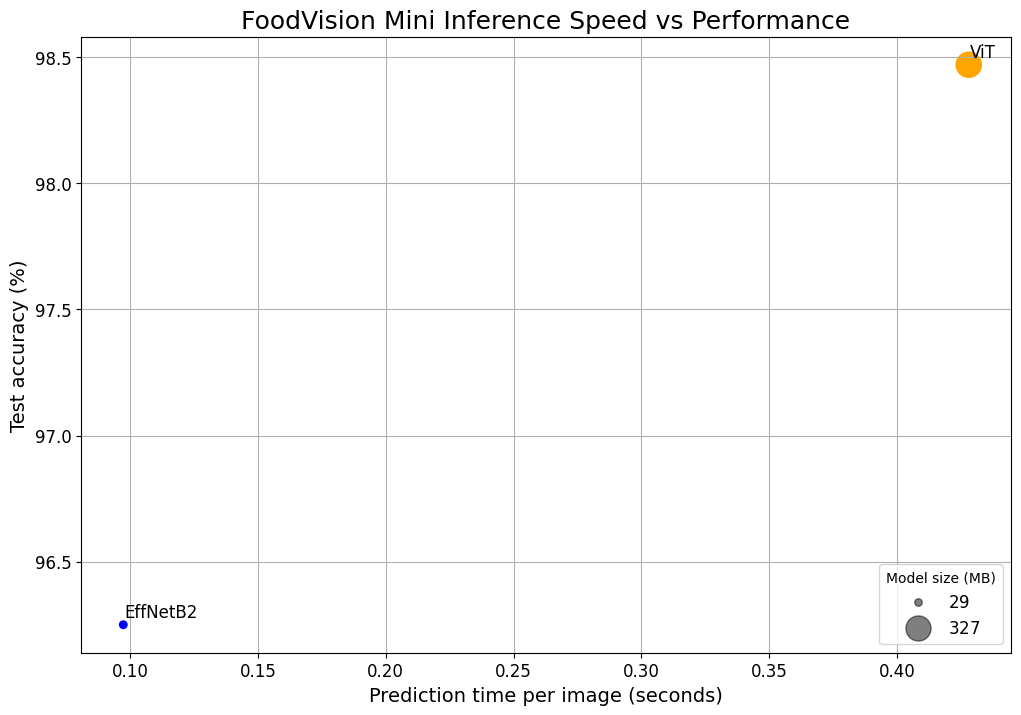

In [ ]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
!mkdir images/
plt.savefig("images/09-foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

##  Bringing FoodVision Mini to life by creating a Gradio demo

We've decided we'd like to deploy the EffNetB2 model.

There are several ways to deploy a machine learning model each with specific use cases.

We're going to be focused on perhaps the quickest and certainly one of the most fun ways to get a model deployed to the internet.

> Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere!

Because metrics on the test set look nice but you never really know how your model performs until you use it in the wild.

So let's get deploying!

We'll start by importing Gradio with the common alias `gr` and if it's not present, we'll install it.

In [ ]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

Gradio version: 5.42.0


###  Creating a function to map our inputs and outputs

To create our FoodVision Mini demo with Gradio, we'll need a function to map our inputs to our outputs.

We created a function earlier called `pred_and_store()` to make predictions with a given model across a list of target files and store them in a list of dictionaries.

How about we create a similar function but this time focusing on making a prediction on a single image with our EffNetB2 model?

More specifically, we want a function that takes an image as input, preprocesses (transforms) it, makes a prediction with EffNetB2 and then returns the prediction (pred or pred label for short) as well as the prediction probability (pred prob).

And while we're here, let's return the time it took to do so too:

```
input: image -> transform -> predict with EffNetB2 -> output: pred, pred prob, time taken
```

This will be our `fn` parameter for our Gradio interface.

In [ ]:
# Put EffNetB2 on CPU
effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [ ]:
from typing import Tuple,Dict
def predict(img) -> Tuple[Dict, float]:
    """
    Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

In [ ]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/sushi/2903125.jpg

Prediction label and probability dictionary: 
{'pizza': 0.14047735929489136, 'steak': 0.057762522250413895, 'sushi': 0.8017601370811462}
Prediction time: 0.08349 seconds


### Creating a list of example images

Our `predict()` function enables us to go from inputs -> transform -> ML model -> outputs.

Which is exactly what we need for our Graido demo.

But before we create the demo, let's create one more thing: a list of examples.

Gradio's [`Interface`](https://gradio.app/docs/#interface) class takes a list of `examples` of as an optional parameter (`gradio.Interface(examples=List[Any])`).

And the format for the `examples` parameter is a list of lists.

So let's create a list of lists containing random filepaths to our test images.

Three examples should be enough.

In [ ]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/steak/1302563.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/2475366.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/3541033.jpg']]

###  Building a Gradio interface

Time to put everything together and bring our FoodVision Mini demo to life!

Let's create a Gradio interface to replicate the workflow:

```
input: image -> transform -> predict with EffNetB2 -> output: pred, pred prob, time taken
```

We can do with the [`gradio.Interface()`](https://gradio.app/docs/#interface) class with the following parameters:
* `fn` - a Python function to map `inputs` to `outputs`, in our case, we'll use our `predict()` function.
* `inputs` - the input to our interface, such as an image using [`gradio.Image()`](https://gradio.app/docs/#image) or `"image"`.
* `outputs` - the output of our interface once the `inputs` have gone through the `fn`, such as a label using [`gradio.Label()`](https://gradio.app/docs/#label) (for our model's predicted labels) or number using [`gradio.Number()`](https://gradio.app/docs/#number) (for our model's prediction time).
    * **Note:** Gradio comes with many in-built `inputs` and `outputs` options known as ["Components"](https://gradio.app/docs/#components).
* `examples` - a list of examples to showcase for the demo.
* `title` - a string title of the demo.
* `description` - a string description of the demo.
* `article` - a reference note at the bottom of the demo.

Once we've created our demo instance of `gr.Interface()`, we can bring it to life using [`gradio.Interface().launch()`](https://gradio.app/docs/#launch-header) or `demo.launch()` command.


In [ ]:
import gradio as gr

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create the Gradio demo
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally
            share=True) # generate a publically shareable URL

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4cf73837a51ed8c9a5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


##  Turning our FoodVision Mini Gradio Demo into a deployable app

We've seen our FoodVision Mini model come to life through a Gradio demo.

But what if we wanted to share it with our friends

Well, we could use the provided Gradio link, however, the shared link only lasts for 1 week.

To make our FoodVision Mini demo more permanent, we can package it into an app and upload it to [Hugging Face Spaces](https://huggingface.co/spaces/launch).

### Deployed Gradio app structure

To upload our demo Gradio app, we'll want to put everything relating to it into a single directory.

For example, our demo might live at the path `demos/foodvision_mini/` with the file structure:

```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

Where:
* `pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth` is our trained PyTorch model file.
* `app.py` contains our Gradio app (similar to the code that launched the app).
    * **Note:** `app.py` is the default filename used for Hugging Face Spaces, if you deploy your app there, Spaces will by default look for a file called `app.py` to run. This is changeable in settings.
* `examples/` contains example images to use with our Gradio app.
* `model.py` contains the model definition as well as any transforms associated with the model.
* `requirements.txt` contains the dependencies to run our app such as `torch`, `torchvision` and `gradio`.



### Creating a `demos` folder to store our FoodVision Mini app files

To begin, let's first create a `demos/` directory to store all of our FoodVision Mini app files.

We can do with Python's [`pathlib.Path("path_to_dir")`](https://docs.python.org/3/library/pathlib.html#basic-use) to establish the directory path and [`pathlib.Path("path_to_dir").mkdir()`](https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir) to create it.

In [ ]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might already exist there and create new directory
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
# If the file doesn't exist, create it anyway
foodvision_mini_demo_path.mkdir(parents=True,
                                exist_ok=True)

# Check what's in the folder
!ls demos/foodvision_mini/

### Creating a folder of example images to use with our FoodVision Mini demo

Now we've got a directory to store our FoodVision Mini demo files, let's add some examples to it.

Three example images from the test dataset should be enough.

To do so we'll:
1. Create an `examples/` directory within the `demos/foodvision_mini` directory.
2. Choose three random images from the test dataset and collect their filepaths in a list.
3. Copy the three random images from the test dataset to the `demos/foodvision_mini/examples/` directory.

In [ ]:
import shutil
from pathlib import Path

# 1. Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


In [ ]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/592799.jpg'], ['examples/2582289.jpg'], ['examples/3622237.jpg']]

### Moving our trained EffNetB2 model to our FoodVision Mini demo directory

We previously saved our FoodVision Mini EffNetB2 feature extractor model under `models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth`.

And rather double up on saved model files, let's move our model to our `demos/foodvision_mini` directory.

We can do so using Python's [`shutil.move()`](https://docs.python.org/3/library/shutil.html#shutil.move) method and passing in `src` (the source path of the target file) and `dst` (the destination path of the target file to be moved to) parameters.

In [ ]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path,
                dst=effnetb2_foodvision_mini_model_destination)

    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


### Turning our EffNetB2 model into a Python script (`model.py`)

Our current model's `state_dict` is saved to `demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth`.

To load it in we can use `model.load_state_dict()` along with `torch.load()`.

> **Note:** For a refresh on saving and loading a model (or a model's `state_dict` in PyTorch, see [01. PyTorch Workflow Fundamentals section 5: Saving and loading a PyTorch model](https://www.learnpytorch.io/01_pytorch_workflow/#5-saving-and-loading-a-pytorch-model) or see the PyTorch recipe for [What is a `state_dict` in PyTorch?](https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html)

But before we can do this, we first need a way to instantiate a `model`.

To do this in a modular fashion we'll create a script called `model.py` which contains our `create_effnetb2_model()` function we created in [section 3.1: *Creating a function to make an EffNetB2 feature extractor*](https://www.learnpytorch.io/09_pytorch_model_deployment/#31-creating-a-function-to-make-an-effnetb2-feature-extractor).

That way we can import the function in *another* script (see `app.py` below) and then use it to create our EffNetB2 `model` instance as well as get its appropriate transforms.



In [ ]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvision_mini/model.py


###  Turning our FoodVision Mini Gradio app into a Python script (`app.py`)

We've now got a `model.py` script as well as a path to a saved model `state_dict` that we can load in.

Time to construct `app.py`.

We call it `app.py` because by default when you create a HuggingFace Space, it looks for a file called `app.py` to run and host (though you can change this in settings).

Our `app.py` script will put together all of the pieces of the puzzle to create our Gradio demo and will have four main parts:

1. **Imports and class names setup** - Here we'll import the various dependencies for our demo including the `create_effnetb2_model()` function from `model.py` as well as setup the different class names for our FoodVision Mini app.
2. **Model and transforms preparation** - Here we'll create an EffNetB2 model instance along with the transforms to go with it and then we'll load in the saved model weights/`state_dict`. When we load the model we'll also set `map_location=torch.device("cpu")` in [`torch.load()`](https://pytorch.org/docs/stable/generated/torch.load.html) so our model gets loaded onto the CPU regardless of the device it trained on (we do this because we won't necessarily have a GPU when we deploy and we'll get an error if our model is trained on GPU but we try to deploy it to CPU without explicitly saying so).
3. **Predict function** - Gradio's `gradio.Interface()` takes a `fn` parameter to map inputs to outputs, our `predict()` function will be the same as the one we defined above, it will take in an image and then use the loaded transforms to preprocess it before using the loaded model to make a prediction on it.
    * **Note:** We'll have to create the example list on the fly via the `examples` parameter. We can do so by creating a list of the files inside the `examples/` directory with: `[["examples/" + example] for example in os.listdir("examples")]`.
4. **Gradio app** - This is where the main logic of our demo will live, we'll create a `gradio.Interface()` instance called `demo` to put together our inputs, `predict()` function and outputs. And we'll finish the script by calling `demo.launch()` to launch our FoodVision Mini demo!

In [ ]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3,
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_mini/app.py


### Creating a requirements file for FoodVision Mini (`requirements.txt`)

The last file we need to create for our FoodVision Mini app is a [`requirements.txt` file](https://learnpython.com/blog/python-requirements-file/).

This will be a text file containing all of the required dependencies for our demo.

When we deploy our demo app to Hugging Face Spaces, it will search through this file and install the dependencies we define so our app can run.

The good news is, there's only three!

1. `torch`
2. `torchvision`
3. `gradio`

In [ ]:
%%writefile demos/foodvision_mini/requirements.txt
torch
torchvision
gradio

Writing demos/foodvision_mini/requirements.txt


## Deploying our FoodVision Mini app to HuggingFace Spaces

We've got a file containing our FoodVision Mini demo, now how do we get it to run on Hugging Face Spaces?

There are two main options for uploading to a Hugging Face Space (also called a [Hugging Face Repository](https://huggingface.co/docs/hub/repositories-getting-started#getting-started-with-repositories), similar to a git repository):
1. [Uploading via the Hugging Face Web interface (easiest)](https://huggingface.co/docs/hub/repositories-getting-started#adding-files-to-a-repository-web-ui).
2. [Uploading via the command line or terminal](https://huggingface.co/docs/hub/repositories-getting-started#terminal).
    * **Bonus:** You can also use the [`huggingface_hub` library](https://huggingface.co/docs/huggingface_hub/index) to interact with Hugging Face, this would be a good extension to the above two options.

**we**'re going to go with option two
.

### Downloading our FoodVision Mini app files

Let's check out the demo files we've got inside `demos/foodvision_mini`.

To do so we can use the `!ls` command followed by the target filepath.

`ls` stands for "list" and the `!` means we want to execute the command at the shell level.

In [ ]:
!ls demos/foodvision_mini

app.py
examples
model.py
pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
requirements.txt


In [ ]:
# Change into and then zip the foodvision_mini folder but exclude certain files
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Mini app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_mini.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

  adding: app.py (deflated 57%)
  adding: examples/ (stored 0%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: model.py (deflated 55%)
  adding: pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Running our FoodVision Mini demo locally

If you download the `foodvision_mini.zip` file, you can test it locally by:
1. Unzipping the file.
2. Opening terminal or a command line prompt.
3. Changing into the `foodvision_mini` directory (`cd foodvision_mini`).
4. Creating an environment (`python3 -m venv env`).
5. Activating the environment (`source env/bin/activate`).
5. Installing the requirements (`pip install -r requirements.txt`, the "`-r`" is for recursive).
    * **Note:** This step may take 5-10 minutes depending on your internet connection. And if you're facing errors, you may need to upgrade `pip` first: `pip install --upgrade pip`.
6. Run the app (`python3 app.py`).

This should result in a Gradio demo just like the one we built above running locally on your machine at a URL such as `http://127.0.0.1:7860/`.



### Uploading to Hugging Face

We've verified our FoodVision Mini app works locally, however, the fun of creating a machine learning demo is to show it to other people and allow them to use it.

To do so, we're going to upload our FoodVision Mini demo to Hugging Face.

> **Note:** The following series of steps uses a Git (a file tracking system) workflow. For more on how Git works, I'd recommend going through the [Git and GitHub for Beginners tutorial](https://youtu.be/RGOj5yH7evk) on freeCodeCamp.

1. [Sign up](https://huggingface.co/join) for a Hugging Face account.
2. Start a new Hugging Face Space by going to your profile and then [clicking "New Space"](https://huggingface.co/new-space).
    * **Note:** A Space in Hugging Face is also known as a "code repository" (a place to store your code/files) or "repo" for short.
3. Give the Space a name, for example, mine is called `mrdbourke/foodvision_mini`, you can see it here: https://huggingface.co/spaces/mrdbourke/foodvision_mini
4. Select a license (I used [MIT](https://opensource.org/licenses/MIT)).
5. Select Gradio as the Space SDK (software development kit).
   * **Note:** You can use other options such as Streamlit but since our app is built with Gradio, we'll stick with that.
6. Choose whether your Space is it's public or private (I selected public since I'd like my Space to be available to others).
7. Click "Create Space".
8. Clone the repo locally by running something like: `git clone https://huggingface.co/spaces/[YOUR_USERNAME]/[YOUR_SPACE_NAME]` in terminal or command prompt.
    * **Note:** You can also add files via uploading them under the "Files and versions" tab.
9. Copy/move the contents of the downloaded `foodvision_mini` folder to the cloned repo folder.
10. To upload and track larger files (e.g. files over 10MB or in our case, our PyTorch model file) you'll need to [install Git LFS](https://git-lfs.github.com/) (which stands for "git large file storage").
11. After you've installed Git LFS, you can activate it by running `git lfs install`.
12. In the `foodvision_mini` directory, track the files over 10MB with Git LFS with `git lfs track "*.file_extension"`.
    * Track EffNetB2 PyTorch model file with `git lfs track "09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"`.
13. Track `.gitattributes` (automatically created when cloning from HuggingFace, this file will help ensure our larger files are tracked with Git LFS). You can see an example `.gitattributes` file on the [FoodVision Mini Hugging Face Space](https://huggingface.co/spaces/mrdbourke/foodvision_mini/blob/main/.gitattributes).
    * `git add .gitattributes`
14. Add the rest of the `foodvision_mini` app files and commit them with:
    * `git add *`
    * `git commit -m "first commit"`
15. Push (upload) the files to Hugging Face:
    * `git push`
16. Wait 3-5 minutes for the build to happen (future builds are faster) and your app to become live!

If everything worked, you should see a live running example of our FoodVision Mini Gradio demo like the one here: https://huggingface.co/spaces/mrdbourke/foodvision_mini

And we can even embed our FoodVision Mini Gradio demo into our notebook as an [iframe](https://gradio.app/sharing_your_app/#embedding-with-iframes) with [`IPython.display.IFrame`](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html#IPython.display.IFrame) and a link to our space in the format `https://hf.space/embed/[YOUR_USERNAME]/[YOUR_SPACE_NAME]/+`.

In [ ]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
IFrame(src="https://huggingface.co/spaces/NG-2004/Foodvision_mini/tree/main+", width=900, height=750)

## Creating FoodVision Big

We've spent the past few sections and chapters working on bringing FoodVision Mini to life.

And now we've seen it working in a live demo, how about we step things up a notch?

FoodVision Big!

Since FoodVision Mini is trained on pizza, steak and sushi images from the [Food101 dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html) (101 classes of food x 1000 images each), how about we make FoodVision Big by training a model on all 101 classes!

We'll go from three classes to 101

From pizza, steak, sushi to pizza, steak, sushi, hot dog, apple pie, carrot cake, chocolate cake, french fries, garlic bread, ramen, nachos, tacos and more!

Well, we've got all the steps in place, all we have to do is alter our EffNetB2 model slightly as well as prepare a different dataset.


### Creating a model and transforms for FoodVision Big

When creating FoodVision Mini we saw that the EffNetB2 model was a good tradeoff between speed and performance (it performed well with a fast speed).

So we'll continue using the same model for FoodVision Big.

We can create an EffNetB2 feature extractor for Food101 by using our `create_effnetb2_model()` function we created above#31-creating-a-function-to-make-an-effnetb2-feature-extractor), and passing it the parameter `num_classes=101` (since Food101 has 101 classes).

In [ ]:
# Create EffNetB2 model capable of fitting to 101 classes for Food101
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

In [ ]:
from torchinfo import summary

# Get a summary of EffNetB2 feature extractor for Food101 with 101 output classes (uncomment for full output)
summary(effnetb2_food101,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:
# Create Food101 training data transforms (only perform data augmentation on the training images)
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms,
])

In [ ]:
print(f"Training transforms:\n{food101_train_transforms}\n")
print(f"Testing transforms:\n{effnetb2_transforms}")

Training transforms:
Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

Testing transforms:
ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


### Getting data for FoodVision Big

To get the whole Food101 dataset, we can use [`torchvision.datasets.Food101()`](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html).

We'll first setup a path to directory `data/` to store the images.

Then we'll download and transform the training and testing dataset splits using `food101_train_transforms` and `effnetb2_transforms` to transform each dataset respectively.

> **Note:** If you're using Google Colab, the cell below will take ~3-5 minutes to fully run and download the Food101 images from PyTorch.
>
> This is because there is over 100,000 images being downloaded (101 classes x 1000 images per class). If you restart your Google Colab runtime and come back to this cell, the images will have to redownload. Alternatively, if you're running this notebook locally, the images will be cached and stored in the directory specified by the `root` parameter of `torchvision.datasets.Food101()`.  

In [ ]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get training data (~750 images x 101 food classes)
train_data = datasets.Food101(root=data_dir, # path to download data to
                              split="train", # dataset split to get
                              transform=food101_train_transforms, # perform data augmentation on training data
                              download=True) # want to download?

# Get testing data (~250 images x 101 food classes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetb2_transforms, # perform normal EffNetB2 transforms on test data
                             download=True)

100%|██████████| 5.00G/5.00G [03:46<00:00, 22.1MB/s]


In [ ]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42):
    """Randomly splits a given dataset into two proportions based on split_size and seed.

    Args:
        dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
        split_size (float, optional): How much of the dataset should be split?
            E.g. split_size=0.2 means there will be a 20% split and an 80% split. Defaults to 0.2.
        seed (int, optional): Seed for random generator. Defaults to 42.

    Returns:
        tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and
            random_split_2 is of size (1-split_size)*len(dataset).
    """
    # Create split lengths based on original dataset length
    length_1 = int(len(dataset) * split_size) # desired length
    length_2 = len(dataset) - length_1 # remaining length

    # Print out info
    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")

    # Create splits with given random seed
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(seed)) # set the random seed for reproducible splits
    return random_split_1, random_split_2

In [ ]:
# Create training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split of Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


(15150, 5050)

### Turning our Food101 datasets into `DataLoader`s

Now let's turn our Food101 20% dataset splits into `DataLoader`'s using `torch.utils.data.DataLoader()`.

We'll set `shuffle=True` for the training data only and the batch size to `32` for both datasets.

And we'll set `num_workers` to `4` if the CPU count is available or `2` if it's not (though the value of `num_workers` is very experimental and will depend on the hardware you're using, there's an [active discussion thread about this on the PyTorch forums](https://discuss.pytorch.org/t/guidelines-for-assigning-num-workers-to-dataloader/813)).

In [ ]:
import os
import torch

BATCH_SIZE = 32
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4 # this value is very experimental and will depend on the hardware you have available, Google Colab generally provides 2x CPUs

# Create Food101 20 percent training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)
# Create Food101 20 percent testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)

### Training FoodVision Big model

FoodVision Big model and `DataLoader`s ready!

Time for training.

We'll create an optimizer using `torch.optim.Adam()` and a learning rate of `1e-3`.

And because we've got so many classes, we'll also setup a loss function using `torch.nn.CrossEntropyLoss()` with `label_smoothing=0.1`, inline with [`torchvision`'s state-of-the-art training recipe](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#label-smoothing).

What's [**label smoothing**](https://paperswithcode.com/method/label-smoothing)?

Label smoothing is a regularization technique (regularization is another word to describe the process of [preventing overfitting](https://www.learnpytorch.io/04_pytorch_custom_datasets/#81-how-to-deal-with-overfitting)) that reduces the value a model gives to anyone label and spreads it across the other labels.

In essence, rather than a model getting *too confident* on a single label, label smoothing gives a non-zero value to other labels to help aid in generalization.

For example, if a model *without* label smoothing had the following outputs for 5 classes:

```
[0, 0, 0.99, 0.01, 0]
```

A model *with* label smoothing may have the following outputs:

```
[0.01, 0.01, 0.96, 0.01, 0.01]
```

The model is still confident on its prediction of class 3 but giving small values to the other labels forces the model to at least consider other options.

Finally, to keep things quick, we'll train our model for five epochs using the `engine.train()` function we created with the goal of beating the original Food101 paper's result of 56.4% accuracy on the test set.

Let's train our biggest model yet!


In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # throw in a little label smoothing because so many classes

# Want to beat original Food101 paper with 20% of data, need 56.4%+ acc on test dataset
set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6422 | train_acc: 0.2795 | test_loss: 2.7824 | test_acc: 0.4903
Epoch: 2 | train_loss: 2.8626 | train_acc: 0.4410 | test_loss: 2.4729 | test_acc: 0.5334
Epoch: 3 | train_loss: 2.6559 | train_acc: 0.4866 | test_loss: 2.3633 | test_acc: 0.5556
Epoch: 4 | train_loss: 2.5455 | train_acc: 0.5124 | test_loss: 2.3022 | test_acc: 0.5751
Epoch: 5 | train_loss: 2.4963 | train_acc: 0.5235 | test_loss: 2.2799 | test_acc: 0.5810


### Inspecting loss curves of FoodVision Big model

Let's make our FoodVision Big loss curves visual.

We can do so with the `plot_loss_curves()` function from `helper_functions.py`.

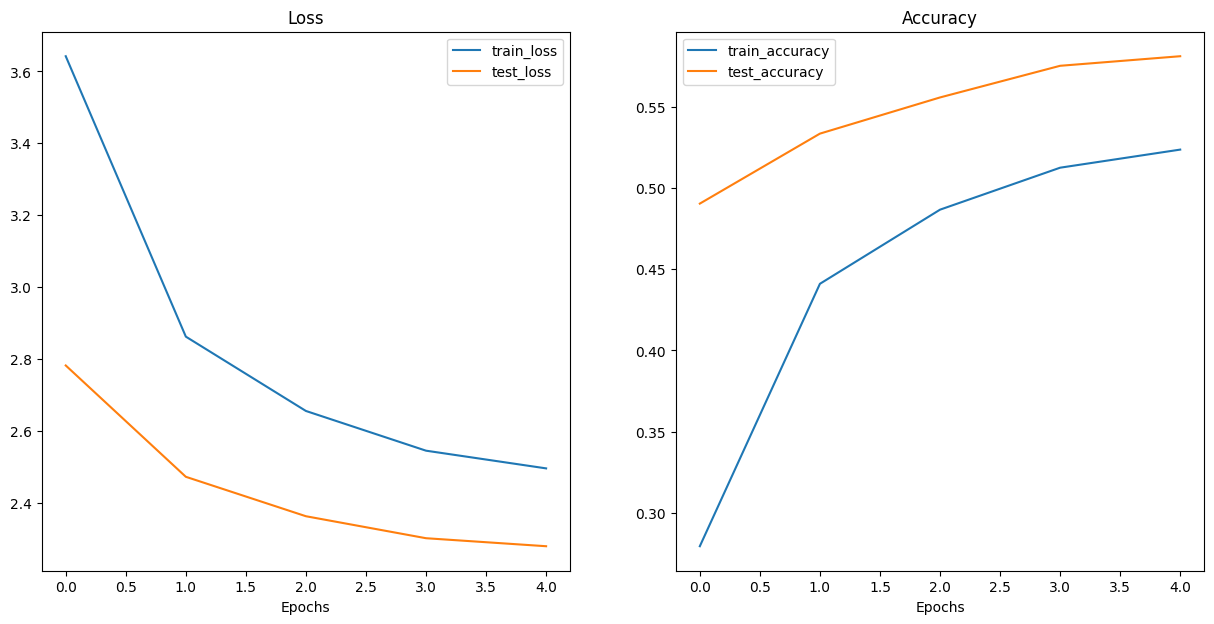

In [ ]:
from helper_functions import plot_loss_curves

# Check out the loss curves for FoodVision Big
plot_loss_curves(effnetb2_food101_results)

### Saving and loading FoodVision Big

In [ ]:
from going_modular.going_modular import utils

# Create a model path
effnetb2_food101_model_path = "pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

# Save FoodVision Big model
utils.save_model(model=effnetb2_food101,
                 target_dir="models",
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models/pretrained_effnetb2_feature_extractor_food101_20_percent.pth


In [ ]:
# Create Food101 compatible EffNetB2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load the saved model's state_dict()
loaded_effnetb2_food101.load_state_dict(torch.load("models/pretrained_effnetb2_feature_extractor_food101_20_percent.pth"))

<All keys matched successfully>

### Checking FoodVision Big model size

Our FoodVision Big model is capable of classifying 101 classes versus FoodVision Mini's 3 classes, a 33.6x increase

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


## Turning our FoodVision Big model into a deployable app

We've got a trained and saved EffNetB2 model on 20% of the Food101 dataset.

And instead of letting our model live in a folder all its life, let's deploy it!

We'll deploy our FoodVision Big model in the same way we deployed our FoodVision Mini model, as a Gradio demo on Hugging Face Spaces.

To begin, let's create a `demos/foodvision_big/` directory to store our FoodVision Big demo files as well as a `demos/foodvision_big/examples` directory to hold an example image to test the demo with.

When we're finished we'll have the following file structure:

```
demos/
  foodvision_big/
    09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt
```

Where:
* `09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth` is our trained PyTorch model file.
* `app.py` contains our FoodVision Big Gradio app.
* `class_names.txt` contains all of the class names for FoodVision Big.
* `examples/` contains example images to use with our Gradio app.
* `model.py` contains the model definition as well as any transforms associated with the model.
* `requirements.txt` contains the dependencies to run our app such as `torch`, `torchvision` and `gradio`.

In [ ]:
from pathlib import Path

# Create FoodVision Big demo path
foodvision_big_demo_path = Path("demos/foodvision_big/")

# Make FoodVision Big demo directory
foodvision_big_demo_path.mkdir(parents=True, exist_ok=True)

# Make FoodVision Big demo examples directory
(foodvision_big_demo_path / "examples").mkdir(parents=True, exist_ok=True)

### Downloading an example image and moving it to the `examples` directory

For our example image, we're going to use the faithful [`pizza-dad` image](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg) (a photo of my dad eating pizza).

So let's download it from the course GitHub via the `!wget` command and then we can move it to `demos/foodvision_big/examples` with the `!mv` command (short for "move").

While we're here we'll move our trained Food101 EffNetB2 model from `models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth` to `demos/foodvision_big` as well.

In [ ]:
# Download and move an example image
!wget https://github.com/NANDAGOPALNG/pytorch--going_modular/blob/main/data/04-pizza-dad.jpeg
!mv 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpg

# Move trained model to FoodVision Big demo folder (will error if model is already moved)
!mv models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demos/foodvision_big

--2025-08-25 13:52:14--  https://github.com/NANDAGOPALNG/pytorch--going_modular/blob/main/data/04-pizza-dad.jpeg
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘04-pizza-dad.jpeg’

04-pizza-dad.jpeg       [ <=>                ] 180.34K  1004KB/s    in 0.2s    

2025-08-25 13:52:15 (1004 KB/s) - ‘04-pizza-dad.jpeg’ saved [184673]

mv: cannot stat 'models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth': No such file or directory


### Saving Food101 class names to file (`class_names.txt`)

Because there are so many classes in the Food101 dataset, instead of storing them as a list in our `app.py` file, let's save them to a `.txt` file and read them in when necessary instead.

We'll just remind ourselves what they look like first by checking out `food101_class_names`.

In [ ]:
# Check out the first 10 Food101 class names
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Create path to Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"

# Write Food101 class names list to file
with open(foodvision_big_class_names_path, "w") as f:
    print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
    f.write("\n".join(food101_class_names)) # leave a new line between each class

[INFO] Saving Food101 class names to demos/foodvision_big/class_names.txt


In [ ]:
# Open Food101 class names file and read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
    food101_class_names_loaded = [food.strip() for food in  f.readlines()]

# View the first 5 class names loaded back in
food101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

### Turning our FoodVision Big model into a Python script (`model.py`)

Just like the FoodVision Mini demo, let's create a script that's capable of instantiating an EffNetB2 feature extractor model along with its necessary transforms.

In [ ]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvision_big/model.py


### Turning our FoodVision Big Gradio app into a Python script (`app.py`)

We've got a FoodVision Big `model.py` script, now let's create a FoodVision Big `app.py` script.

This will again mostly be the same as the FoodVision Mini `app.py` script except we'll change:

1. **Imports and class names setup** - The `class_names` variable will be a list for all of the Food101 classes rather than pizza, steak, sushi. We can access these via `demos/foodvision_big/class_names.txt`.
2. **Model and transforms preparation** - The `model` will have `num_classes=101` rather than `num_classes=3`. We'll also be sure to load the weights from `"09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"` (our FoodVision Big model path).
3. **Predict function** - This will stay the same as FoodVision Mini's `app.py`.
4. **Gradio app** - The Gradio interface will have different `title`, `description` and `article` parameters to reflect the details of FoodVision Big.

We'll also make sure to save it to `demos/foodvision_big/app.py` using the `%%writefile` magic command.

In [ ]:
%%writefile demos/foodvision_big/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f: # reading them in from class_names.txt
    class_names = [food_name.strip() for food_name in  f.readlines()]

### 2. Model and transforms preparation ###

# Create model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=101, # could also use len(class_names)
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Big 🍔👁"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food into [101 different classes](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article,
)

# Launch the app!
demo.launch()

Writing demos/foodvision_big/app.py


### Creating a requirements file for FoodVision Big (`requirements.txt`)

Now all we need is a `requirements.txt` file to tell our Hugging Face Space what dependencies our FoodVision Big app requires.

In [ ]:
%%writefile demos/foodvision_big/requirements.txt
torch
torchvision
gradio

Writing demos/foodvision_big/requirements.txt


### Downloading our FoodVision Big app files

We've got all the files we need to deploy our FoodVision Big app on Hugging Face, let's now zip them together and download them.


In [ ]:
# Zip foodvision_big folder but exclude certain files
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Big app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_big.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download()")

  adding: app.py (deflated 54%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/04-pizza-dad.jpg (deflated 80%)
  adding: model.py (deflated 56%)
  adding: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Deploying our FoodVision Big app to HuggingFace Spaces

B, E, A, Utiful!

Time to bring our biggest model of the whole course to life!

Let's deploy our FoodVision Big Gradio demo to Hugging Face Spaces so we can test it interactively and let others experience the magic of our machine learning efforts!

> **Note:** There are [several ways to upload files to Hugging Face Spaces](https://huggingface.co/docs/hub/repositories-getting-started#getting-started-with-repositories). The following steps treat Hugging Face as a git repository to track files. However, you can also upload directly to Hugging Face Spaces via the [web interface](https://huggingface.co/docs/hub/repositories-getting-started#adding-files-to-a-repository-web-ui) or by the [`huggingface_hub` library](https://huggingface.co/docs/huggingface_hub/index).

The good news is, we've already done the steps to do so with FoodVision Mini, so now all we have to do is customize them to suit FoodVision Big:

1. [Sign up](https://huggingface.co/join) for a Hugging Face account.
2. Start a new Hugging Face Space by going to your profile and then [clicking "New Space"](https://huggingface.co/new-space).
    * **Note:** A Space in Hugging Face is also known as a "code repository" (a place to store your code/files) or "repo" for short.
3. Give the Space a name, for example, mine is called `mrdbourke/foodvision_big`, you can see it here: https://huggingface.co/spaces/mrdbourke/foodvision_big
4. Select a license (I used [MIT](https://opensource.org/licenses/MIT)).
5. Select Gradio as the Space SDK (software development kit).
   * **Note:** You can use other options such as Streamlit but since our app is built with Gradio, we'll stick with that.
6. Choose whether your Space is public or private (I selected public since I'd like my Space to be available to others).
7. Click "Create Space".
8. Clone the repo locally by running: `git clone https://huggingface.co/spaces/[YOUR_USERNAME]/[YOUR_SPACE_NAME]` in terminal or command prompt.
    * **Note:** You can also add files via uploading them under the "Files and versions" tab.
9. Copy/move the contents of the downloaded `foodvision_big` folder to the cloned repo folder.
10. To upload and track larger files (e.g. files over 10MB or in our case, our PyTorch model file) you'll need to [install Git LFS](https://git-lfs.github.com/) (which stands for "git large file storage").
11. After you've installed Git LFS, you can activate it by running `git lfs install`.
12. In the `foodvision_big` directory, track the files over 10MB with Git LFS with `git lfs track "*.file_extension"`.
    * Track EffNetB2 PyTorch model file with `git lfs track "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"`.
    * **Note:** If you get any errors uploading images, you may have to track them with `git lfs` too, for example `git lfs track "examples/04-pizza-dad.jpg"`
13. Track `.gitattributes` (automatically created when cloning from HuggingFace, this file will help ensure our larger files are tracked with Git LFS). You can see an example `.gitattributes` file on the [FoodVision Big Hugging Face Space](https://huggingface.co/spaces/mrdbourke/foodvision_big/blob/main/.gitattributes).
    * `git add .gitattributes`
14. Add the rest of the `foodvision_big` app files and commit them with:
    * `git add *`
    * `git commit -m "first commit"`
15. Push (upload) the files to Hugging Face:
    * `git push`
16. Wait 3-5 minutes for the build to happen (future builds are faster) and your app to become live!

If everything worked correctly, our FoodVision Big Gradio demo should be ready to classify!

You can see my version here: https://huggingface.co/spaces/mrdbourke/foodvision_big/

Or we can even embed our FoodVision Big Gradio demo right within our notebook as an [iframe](https://gradio.app/sharing_your_app/#embedding-with-iframes) with [`IPython.display.IFrame`](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html#IPython.display.IFrame) and a link to our space in the format `https://hf.space/embed/[YOUR_USERNAME]/[YOUR_SPACE_NAME]/+`.

In [ ]:
# IPython is a library to help work with Python interactively
from IPython.display import IFrame

# Embed FoodVision Big Gradio demo as an iFrame
IFrame(src="https://huggingface.co/spaces/NG-2004/Food_Vision_101", width=900, height=750)